In [ ]:
import string
import nltk
import nest_asyncio
import itertools
import gensim
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from textblob import TextBlob as tb
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from wordcloud import WordCloud
from itertools import chain

nest_asyncio.apply()
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
training=pd.read_excel("/content/training.xlsx")
training.head()

,Date,Title,Summary,Sentiment
0,2021-12-10,Sengketa tanah muncul setelah Sepaku-Penajam d...,Penetapan sebagian wilayah di Kabupaten Penaja...,Negative
1,2021-12-14,"Satgas Pembangunan Ibu Kota Baru Terbentuk, Di...",Mantan Direktur Jenderal Cipta Karya Kementeri...,Neutral
2,2021-12-10,"Pansus RUU IKN Bengkak usai Aturan Diubah, Bal...","Wakil Ketua Badan Legislasi (Baleg) DPR RI, Ac...",Negative
3,2021-12-16,IKN Baru Jangan Bikin Luka Baru,"Menteri Pekerjaan Umum dan Perumahan Rakyat, B...",Positive
4,2021-12-27,Refleksi Akhir Tahun KAMI Lintas Provinsi: Pem...,"Dalam keterangan berjudul ""Refleksi Akhir Tahu...",Positive


Preprocessing

In [ ]:
# ------ Case Folding --------
# gunakan fungsi Series.str.lower() pada Pandas
training['clean_title'] = training['Title'].str.lower()


print('Case Folding Result : \n')
training.head()

Case Folding Result : 



,Date,Title,Summary,Sentiment,clean_title
0,2021-12-10,Sengketa tanah muncul setelah Sepaku-Penajam d...,Penetapan sebagian wilayah di Kabupaten Penaja...,Negative,sengketa tanah muncul setelah sepaku-penajam d...
1,2021-12-14,"Satgas Pembangunan Ibu Kota Baru Terbentuk, Di...",Mantan Direktur Jenderal Cipta Karya Kementeri...,Neutral,"satgas pembangunan ibu kota baru terbentuk, di..."
2,2021-12-10,"Pansus RUU IKN Bengkak usai Aturan Diubah, Bal...","Wakil Ketua Badan Legislasi (Baleg) DPR RI, Ac...",Negative,"pansus ruu ikn bengkak usai aturan diubah, bal..."
3,2021-12-16,IKN Baru Jangan Bikin Luka Baru,"Menteri Pekerjaan Umum dan Perumahan Rakyat, B...",Positive,ikn baru jangan bikin luka baru
4,2021-12-27,Refleksi Akhir Tahun KAMI Lintas Provinsi: Pem...,"Dalam keterangan berjudul ""Refleksi Akhir Tahu...",Positive,refleksi akhir tahun kami lintas provinsi: pem...


In [ ]:
import re, string, unicodedata  #modul regular expression 
import nltk
from nltk import word_tokenize, sent_tokenize  #Paket ini membagi teks input menjadi kata-kata.,                                  
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize
#remove stopwords and remove slang word
New_word_stop_list = [ 'tak','yg', 'ya', 'dg', 'dgn', 'nich', 'nih', 'sih', 'si', 'nya', 
              	'lg', 'dulu', 'jgn', 'kl', 'klu', 'klo', 'kalo', 'nge',
                   	'sip', 'spt', 'hallo', 'halo', 'ny', 'd', 'biar', 'skrg',
                   	'bikin', 'bilang', 'tau', 'utk', 'jd', 'yah', 'loh', 'lho', 'aj', 'aja',
                   	'cm', 'banget', 'deh', 'dimana', 'for', 'i', 'coba', 'it', 'sy', 'lumayan',
                   	'kasih', 'tingkat',
                     "min" , "tidak", "saya", "kenapa", "wib", "dah", "oke", "gaada",
                     "tidak_ada",'tdk','gak','enggak','ga','-']
def removeStopword(str):
    stop_words = set(stopwords.words('indonesian'))
    word_tokens = word_tokenize(str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words and w not in New_word_stop_list ]
    return ' '.join(filtered_sentence)
def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    return str
def preprocessing( title):

    title = str( title )
    title  = removeStopword( title )
    title=cleaning(title)
    #print( str )
    
    return title

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import nltk
nltk.download('stopwords')

training["clean_title"] = training["clean_title"].apply( lambda row : preprocessing( row ) )

training.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Date,Title,Summary,Sentiment,clean_title
0,2021-12-10,Sengketa tanah muncul setelah Sepaku-Penajam d...,Penetapan sebagian wilayah di Kabupaten Penaja...,Negative,sengketa tanah muncul sepaku penajam ditetapka...
1,2021-12-14,"Satgas Pembangunan Ibu Kota Baru Terbentuk, Di...",Mantan Direktur Jenderal Cipta Karya Kementeri...,Neutral,satgas pembangunan kota terbentuk diketuai dan...
2,2021-12-10,"Pansus RUU IKN Bengkak usai Aturan Diubah, Bal...","Wakil Ketua Badan Legislasi (Baleg) DPR RI, Ac...",Negative,pansus ruu ikn bengkak aturan diubah baleg dal...
3,2021-12-16,IKN Baru Jangan Bikin Luka Baru,"Menteri Pekerjaan Umum dan Perumahan Rakyat, B...",Positive,ikn luka
4,2021-12-27,Refleksi Akhir Tahun KAMI Lintas Provinsi: Pem...,"Dalam keterangan berjudul ""Refleksi Akhir Tahu...",Positive,refleksi lintas provinsi pemerintah gagal pera...


In [ ]:
# Normalisasi Data

normalized_word = pd.read_excel("/content/normalisasi.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

def normalized_tweets( tweets_text ):

    tweets_words_list = tweets_text.split( " " )

    normalized_tweets_text = ""

    for word in tweets_words_list :

        if word in normalized_word_dict :
          normalized_tweets_text = normalized_tweets_text + " " + normalized_word_dict[ word ]
        else :
          normalized_tweets_text = normalized_tweets_text + " " + word
    
    return normalized_tweets_text


training["normalized_and_preprocessed_tweets_text"] = training["clean_title"].apply( lambda row : normalized_tweets( row ) )

training


,Date,Title,Summary,Sentiment,clean_title,normalized_and_preprocessed_tweets_text
0,2021-12-10,Sengketa tanah muncul setelah Sepaku-Penajam d...,Penetapan sebagian wilayah di Kabupaten Penaja...,Negative,sengketa tanah muncul sepaku penajam ditetapka...,sengketa tanah muncul sepaku penajam ditetapk...
1,2021-12-14,"Satgas Pembangunan Ibu Kota Baru Terbentuk, Di...",Mantan Direktur Jenderal Cipta Karya Kementeri...,Neutral,satgas pembangunan kota terbentuk diketuai dan...,satgas pembangunan kota terbentuk diketuai da...
2,2021-12-10,"Pansus RUU IKN Bengkak usai Aturan Diubah, Bal...","Wakil Ketua Badan Legislasi (Baleg) DPR RI, Ac...",Negative,pansus ruu ikn bengkak aturan diubah baleg dal...,pansus ruu ikn bengkak aturan diubah baleg da...
3,2021-12-16,IKN Baru Jangan Bikin Luka Baru,"Menteri Pekerjaan Umum dan Perumahan Rakyat, B...",Positive,ikn luka,ikn luka
4,2021-12-27,Refleksi Akhir Tahun KAMI Lintas Provinsi: Pem...,"Dalam keterangan berjudul ""Refleksi Akhir Tahu...",Positive,refleksi lintas provinsi pemerintah gagal pera...,refleksi lintas provinsi pemerintah gagal per...
...,...,...,...,...,...,...
1046,2021-12-08,"Kemarin, Pansus RUU IKN hingga instruksi lanju...",Beragam peristiwa bidang politik terjadi di In...,Neutral,kemarin pansus ruu ikn instruksi lanjutan ppkm,kemarin pansus ruu ikn instruksi lanjutan ppkm
1047,2021-12-23,Terkait RUU Ibu Kota Negara Forum Dayak Bersat...,Ketua Panitia Khusus (Pansus) Ibu Kota Negara ...,Neutral,terkait ruu kota negara forum dayak bersatu as...,terkait ruu kota negara forum dayak bersatu a...
1048,2021-12-13,Rakyat Butuh Kesejahteraan Bukan Ibu Kota Baru,JAKARTA- Pengamat politik dari Universitas Al ...,Neutral,rakyat butuh kesejahteraan kota,rakyat butuh kesejahteraan kota
1049,2021-12-14,"Rekam Jejak Danis Sumadilaga, Ketua Satgas Pem...",Menteri Pekerjaan Umum dan Perumahan Rakyat at...,Neutral,rekam jejak danis sumadilaga ketua satgas pemb...,rekam jejak danis sumadilaga ketua satgas pem...


In [ ]:
allWords = ' '.join([twts for twts in training['Title']])
wordCloud = WordCloud(width=1600, height=800, random_state=30, max_font_size=200, min_font_size=20).generate(allWords)

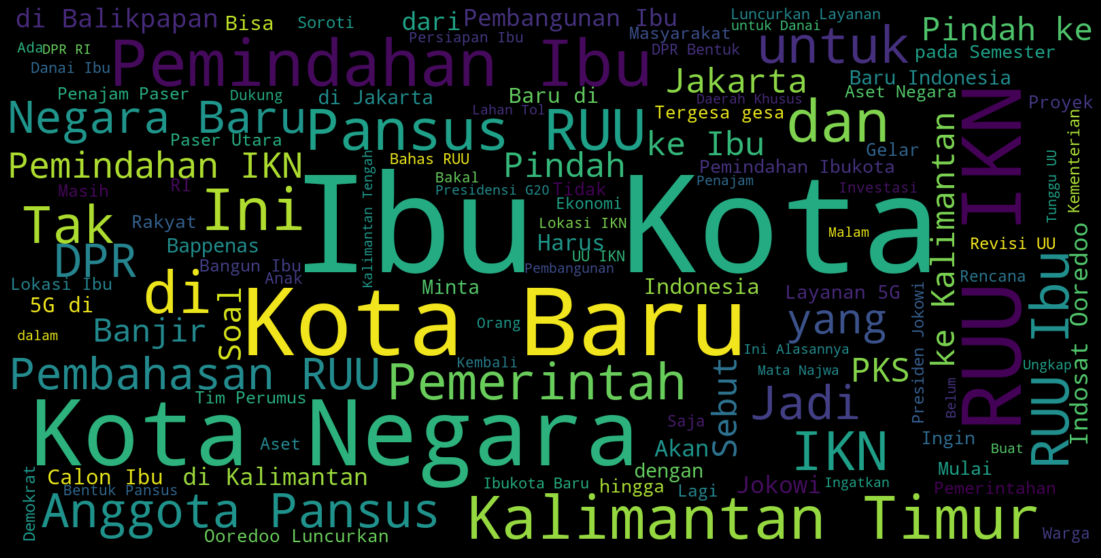

In [ ]:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
#for data wrangling and manipulation

import pandas as pd
import numpy as np

#for NLP text processing and formatting

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# For word lemmitization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# for word Stemming
from nltk.stem.porter import PorterStemmer

# for Machine Learning process

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# for Machine Learning model evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_feature_vector(train_fit):
    """
    Function to Convert a collection of raw documents to a matrix of TF-IDF features.
    TF-IDF - Term Frequency Inverse Documnet Frequency
    """
    
    vector = TfidfVectorizer(sublinear_tf=True)      # Defining the vector
    vector.fit(train_fit)                            # fitting the data into the vector
    return vector                                    # returning the vector as function call

In [ ]:
X_t = tf_vector.transform(np.array(training["normalized_and_preprocessed_tweets_text"]).ravel())     # Predictor Variable

In [ ]:
y=training['Sentiment'].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


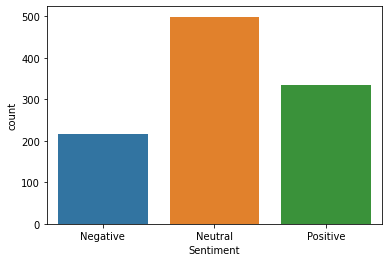

In [ ]:
import seaborn as sns
sns.countplot(training['Sentiment'])

In [ ]:
X=X_t.toarray()

In [ ]:
# SPlitting the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

## Naive Bayes Model

In [ ]:
# Using Naive Bayes Model :

NB_model = GaussianNB()

NB_model.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Predicting the values and the Accuracy Score

y_predict_nb = NB_model.predict(X_test)
print(y_predict_nb)

print("Accuracy Score for Naive Bayes Model is :: ", accuracy_score(y_test, y_predict_nb))

['Positive' 'Negative' 'Positive' 'Negative' 'Negative' 'Negative'
 'Positive' 'Neutral' 'Neutral' 'Neutral' 'Negative' 'Neutral' 'Negative'
 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Positive' 'Negative' 'Positive'
 'Negative' 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Positive' 'Neutral'
 'Neutral' 'Neutral' 'Positive' 'Negative' 'Neutral' 'Negative' 'Negative'
 'Negative' 'Positive' 'Positive' 'Negative' 'Positive' 'Neutral'
 'Negative' 'Positive' 'Neutral' 'Positive' 'Negative' 'Positive'
 'Neutral' 'Neutral' 'Neutral' 'Negative' 'Negative' 'Neutral' 'Neutral'
 'Positive' 'Neutral' 'Positive' 'Neutral' 'Negative' 'Positive' 'Neutral'
 'Negative' 'Negative' 'Positive' 'Negative' 'Neutral' 'Neutral'
 'Positive' 'Negative' 'Negative' 'Neutral' 'Positive' 'Neutral'
 'Negative' 'Negative' 'Neutral' 'Neutral' 'Positive' 'Positive'
 'Positive' 'Negative' 'Negative' 'Negative' 'Neutral' 'Neutral'
 'Negative' 'Negative' 'Positive' 'Neutral' 'Negative' 'Positive'
 'Positive' 'Negative' 'Positiv

In [ ]:
# Classification Report :

print("Classification_Report :: \n\n", classification_report(y_test, y_predict_nb))

Classification_Report :: 

               precision    recall  f1-score   support

    Negative       0.51      0.83      0.63        42
     Neutral       0.82      0.56      0.67       107
    Positive       0.62      0.69      0.66        62

    accuracy                           0.65       211
   macro avg       0.65      0.70      0.65       211
weighted avg       0.70      0.65      0.66       211



## Support Vector Machine (SVM)

In [ ]:
from sklearn import svm
svm=svm.SVC(class_weight=None,C=1,gamma=0.1,kernel='linear',random_state=100)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_pred_svm

array(['Positive', 'Negative', 'Neutral', 'Positive', 'Neutral',
       'Negative', 'Positive', 'Neutral', 'Neutral', 'Neutral',
       'Negative', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Negative',
       'Negative', 'Neutral', 'Positive', 'Neutral', 'Neutral',
       'Negative', 'Neutral', 'Positive', 'Positive', 'Neutral',
       'Positive', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Negative', 'Neutral', 'Neutral', 'Positive',
       'Positive', 'Positive', 'Neutral', 'Positive', 'Positive',
       'Neutral', 'Negative', 'Negative', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral',
       'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Positive', 'Posit

In [ ]:
print("Accuracy Score for Support Vector Machine Model is :: ", accuracy_score(y_test, y_pred_svm))

Accuracy Score for Support Vector Machine Model is ::  0.7772511848341233


In [ ]:
# Classification Report :

print("Classification_Report :: \n\n", classification_report(y_test, y_pred_svm))

Classification_Report :: 

               precision    recall  f1-score   support

    Negative       0.84      0.62      0.71        42
     Neutral       0.75      0.91      0.82       107
    Positive       0.82      0.66      0.73        62

    accuracy                           0.78       211
   macro avg       0.80      0.73      0.75       211
weighted avg       0.79      0.78      0.77       211



##K- Nearest Neighboured

In [ ]:
 from sklearn.neighbors import KNeighborsClassifier
 from sklearn.metrics import accuracy_score 
 for k in [1,3,5,7,10]:

    classifier = KNeighborsClassifier(n_neighbors=k,algorithm='brute') #Using brute-force algorithm for quicker computation.
    classifier.fit(X_train, y_train) #Fitting the built-in sklearn classifier on our training data
    y_predict_knn = classifier.predict(X_test) #Making the classifier to predict on the previously unseen test data.

In [ ]:
print("Accuracy Score for K-Nearest Neighbour is :: ", accuracy_score(y_test, y_predict_knn))

Accuracy Score for K-Nearest Neighbour is ::  0.6777251184834123


In [ ]:
# Classification Report :

print("Classification_Report :: \n\n", classification_report(y_test, y_predict_knn))

Classification_Report :: 

               precision    recall  f1-score   support

    Negative       0.73      0.52      0.61        42
     Neutral       0.67      0.84      0.74       107
    Positive       0.67      0.50      0.57        62

    accuracy                           0.68       211
   macro avg       0.69      0.62      0.64       211
weighted avg       0.68      0.68      0.67       211



Model yang terbaik adalah support vector machine dengan nilai akurasi sebesar 77,725

# Prediksi Testing

In [ ]:
testing=pd.read_excel("/content/testing.xlsx")
testing.head()

,Date,Title,Summary,Sentiment
0,2021-12-14,Ketua KI Pusat hadir malam anugrah sekaligus i...,Ketua Komisi Informasi (KI) Pusat Gede Narayan...,Neutral
1,2021-12-17,"Ramal Gempa dan Tsunami Hantam Pulau Jawa, Den...",Ahli Tarot Denny Darko meramalkan gempa bumi d...,Negative
2,2021-11-28,Pemkot Balikpapan rencanakan bangun pasar induk,"Pemerintah Kota (Pemkot)Balikpapan, Kalimantan...",Neutral
3,2021-12-15,Kapan PNS Pindah ke Ibu Kota Baru di Kalimanta...,Para Pegawai Negeri Sipil (PNS) dikabarkan aka...,Neutral
4,2021-12-24,"Pamer Design Ibu Kota Baru di Kalimantan, Pres...","Ibu kota negara baru di Penajam Paser Utara, K...",Neutral


In [ ]:
# ------ Case Folding --------
# gunakan fungsi Series.str.lower() pada Pandas
testing['clean_title'] = testing['Title'].str.lower()


print('Case Folding Result : \n')
testing.head()

Case Folding Result : 



,Date,Title,Summary,Sentiment,clean_title
0,2021-12-14,Ketua KI Pusat hadir malam anugrah sekaligus i...,Ketua Komisi Informasi (KI) Pusat Gede Narayan...,Neutral,ketua ki pusat hadir malam anugrah sekaligus i...
1,2021-12-17,"Ramal Gempa dan Tsunami Hantam Pulau Jawa, Den...",Ahli Tarot Denny Darko meramalkan gempa bumi d...,Negative,"ramal gempa dan tsunami hantam pulau jawa, den..."
2,2021-11-28,Pemkot Balikpapan rencanakan bangun pasar induk,"Pemerintah Kota (Pemkot)Balikpapan, Kalimantan...",Neutral,pemkot balikpapan rencanakan bangun pasar induk
3,2021-12-15,Kapan PNS Pindah ke Ibu Kota Baru di Kalimanta...,Para Pegawai Negeri Sipil (PNS) dikabarkan aka...,Neutral,kapan pns pindah ke ibu kota baru di kalimanta...
4,2021-12-24,"Pamer Design Ibu Kota Baru di Kalimantan, Pres...","Ibu kota negara baru di Penajam Paser Utara, K...",Neutral,"pamer design ibu kota baru di kalimantan, pres..."


In [ ]:
import re, string, unicodedata  #modul regular expression 
import nltk
from nltk import word_tokenize, sent_tokenize  #Paket ini membagi teks input menjadi kata-kata.,                                  
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize
#remove stopwords and remove slang word
New_word_stop_list = [ 'tak','yg', 'ya', 'dg', 'dgn', 'nich', 'nih', 'sih', 'si', 'nya', 
              	'lg', 'dulu', 'jgn', 'kl', 'klu', 'klo', 'kalo', 'nge',
                   	'sip', 'spt', 'hallo', 'halo', 'ny', 'd', 'biar', 'skrg',
                   	'bikin', 'bilang', 'tau', 'utk', 'jd', 'yah', 'loh', 'lho', 'aj', 'aja',
                   	'cm', 'banget', 'deh', 'dimana', 'for', 'i', 'coba', 'it', 'sy', 'lumayan',
                   	'kasih', 'tingkat',
                     "min" , "tidak", "saya", "kenapa", "wib", "dah", "oke", "gaada",
                     "tidak_ada",'tdk','gak','enggak','ga','-']
def removeStopword(str):
    stop_words = set(stopwords.words('indonesian'))
    word_tokens = word_tokenize(str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words and w not in New_word_stop_list ]
    return ' '.join(filtered_sentence)
def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    return str
def preprocessing( title):

    title = str( title )
    title  = removeStopword( title )
    title=cleaning(title)
    #print( str )
    
    return title

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import nltk
nltk.download('stopwords')

testing["clean_title"] = testing["clean_title"].apply( lambda row : preprocessing( row ) )

testing.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Date,Title,Summary,Sentiment,clean_title
0,2021-12-14,Ketua KI Pusat hadir malam anugrah sekaligus i...,Ketua Komisi Informasi (KI) Pusat Gede Narayan...,Neutral,ketua ki pusat hadir malam anugrah lihat kip k...
1,2021-12-17,"Ramal Gempa dan Tsunami Hantam Pulau Jawa, Den...",Ahli Tarot Denny Darko meramalkan gempa bumi d...,Negative,ramal gempa tsunami hantam pulau jawa denny da...
2,2021-11-28,Pemkot Balikpapan rencanakan bangun pasar induk,"Pemerintah Kota (Pemkot)Balikpapan, Kalimantan...",Neutral,pemkot balikpapan rencanakan bangun pasar induk
3,2021-12-15,Kapan PNS Pindah ke Ibu Kota Baru di Kalimanta...,Para Pegawai Negeri Sipil (PNS) dikabarkan aka...,Neutral,pns pindah kota kalimantan timur
4,2021-12-24,"Pamer Design Ibu Kota Baru di Kalimantan, Pres...","Ibu kota negara baru di Penajam Paser Utara, K...",Neutral,pamer design kota kalimantan presiden angkat k...


In [ ]:
# Normalisasi Data

normalized_word = pd.read_excel("/content/normalisasi.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

def normalized_tweets( tweets_text ):

    tweets_words_list = tweets_text.split( " " )

    normalized_tweets_text = ""

    for word in tweets_words_list :

        if word in normalized_word_dict :
          normalized_tweets_text = normalized_tweets_text + " " + normalized_word_dict[ word ]
        else :
          normalized_tweets_text = normalized_tweets_text + " " + word
    
    return normalized_tweets_text


testing["normalized_and_preprocessed_tweets_text"] = testing["clean_title"].apply( lambda row : normalized_tweets( row ) )

testing.head()


,Date,Title,Summary,Sentiment,clean_title,normalized_and_preprocessed_tweets_text
0,2021-12-14,Ketua KI Pusat hadir malam anugrah sekaligus i...,Ketua Komisi Informasi (KI) Pusat Gede Narayan...,Neutral,ketua ki pusat hadir malam anugrah lihat kip k...,ketua ki pusat hadir malam anugrah lihat kip ...
1,2021-12-17,"Ramal Gempa dan Tsunami Hantam Pulau Jawa, Den...",Ahli Tarot Denny Darko meramalkan gempa bumi d...,Negative,ramal gempa tsunami hantam pulau jawa denny da...,ramal gempa tsunami hantam pulau jawa denny d...
2,2021-11-28,Pemkot Balikpapan rencanakan bangun pasar induk,"Pemerintah Kota (Pemkot)Balikpapan, Kalimantan...",Neutral,pemkot balikpapan rencanakan bangun pasar induk,pemkot balikpapan rencanakan bangun pasar induk
3,2021-12-15,Kapan PNS Pindah ke Ibu Kota Baru di Kalimanta...,Para Pegawai Negeri Sipil (PNS) dikabarkan aka...,Neutral,pns pindah kota kalimantan timur,pns pindah kota kalimantan timur
4,2021-12-24,"Pamer Design Ibu Kota Baru di Kalimantan, Pres...","Ibu kota negara baru di Penajam Paser Utara, K...",Neutral,pamer design kota kalimantan presiden angkat k...,pamer design kota kalimantan presiden angkat ...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_feature_vector(test_fit):
    """
    Function to Convert a collection of raw documents to a matrix of TF-IDF features.
    TF-IDF - Term Frequency Inverse Documnet Frequency
    """
    
    vector = TfidfVectorizer(sublinear_tf=True)      # Defining the vector
    vector.fit(test_fit)                            # fitting the data into the vector
    return vector                                    # returning the vector as function call

In [ ]:
test_feature = tf_vector.transform(np.array(testing['normalized_and_preprocessed_tweets_text']).ravel())
Xtest=test_feature.toarray()

In [ ]:
y_pred_svm = svm.predict(Xtest)

In [ ]:
submission_result = pd.DataFrame({'title': testing.normalized_and_preprocessed_tweets_text, 'sentiment':y_pred_svm})
submission_result

,title,sentiment
0,ketua ki pusat hadir malam anugrah lihat kip ...,Neutral
1,ramal gempa tsunami hantam pulau jawa denny d...,Positive
2,pemkot balikpapan rencanakan bangun pasar induk,Neutral
3,pns pindah kota kalimantan timur,Neutral
4,pamer design kota kalimantan presiden angkat ...,Neutral
...,...,...
446,catatan ahli legislator pks draft ruu ikn dip...,Negative
447,cak imin jokowi kurus kalem jago atasi politik,Positive
448,politisi demokrat jokowi robohkan proyek hamb...,Negative
449,pdip nasdem pimpin tim perumus ruu ikn cek pe...,Neutral


In [ ]:
# Total number os tweets grouped according sentiment

test_result = submission_result['sentiment'].value_counts()
test_result

Neutral     228
Positive    142
Negative     81
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


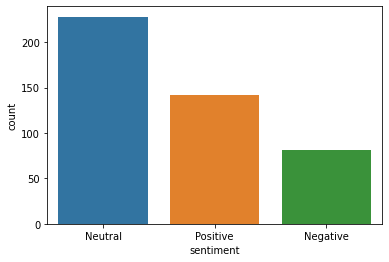

In [ ]:
import seaborn as sns
sns.countplot(submission_result['sentiment'])